In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import calendar
import time

In [2]:
def plot_images(images, grid_size):
    plt.figure(figsize=(8,8))
    for n, image in enumerate(images[0:grid_size**2]):
        plt.subplot(grid_size, grid_size, n + 1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n)

def plot_dataset(d, grid_size, input=True):
    plt.figure(figsize=(8,8))
    for n, images in enumerate(d.take(grid_size**2)):
        plt.subplot(grid_size, grid_size, n + 1)
        image = images[0] if input else images[1]
        plt.imshow(tf.image.convert_image_dtype(image, dtype=tf.uint8))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(n)

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(9, 9), filters=64, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(1, 1), filters=32, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [16]:
def resize(image, size, method):
    resized = tf.image.resize(image, size, method)
    if resized.dtype == tf.uint8:
        return resized
    else:
        return tf.cast(resized, tf.uint8)

def prepare_input_image(original_image, input_h, input_w, scale):
    degraded_image = resize(original_image, size=[input_h // scale, input_w // scale], method=tf.image.ResizeMethod.GAUSSIAN)
    input_image = resize(degraded_image, size=[input_h, input_w], method=tf.image.ResizeMethod.BICUBIC)
    return tf.image.convert_image_dtype(input_image, dtype=tf.float32)

def prepare_output_image(original_image, input_size, output_size):
    if output_size == input_size & output_size == input_size:
        output = original_image
    else:
        new_x = (input_size - output_size) // 2
        new_y = (input_size - output_size) // 2
        output = tf.image.crop_to_bounding_box(original_image, new_y, new_x, output_size, output_size)
    return tf.image.convert_image_dtype(output, dtype=tf.float32)

def prepare_crops(filename, input_size, stride, scale, padding=None):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string)
    if padding is not None:
        image = tf.pad(image, tf.contsant([[padding, padding], [padding, padding], [0, 0]]), "CONSTANT") 
    crops = tf.image.extract_patches(tf.expand_dims(image, 0), [1, input_size, input_size, 1],
                                           [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
    return tf.reshape(crops[0], [-1, input_size, input_size, 3])

def parse_function(filename, input_size, output_size, stride, scale):
    crops = prepare_crops(filename, input_size, stride, scale)
    input_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_input_image(img, input_size, input_size, scale))
    output_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_output_image(img, input_size, output_size))
    result = tf.data.Dataset.zip((input_dataset, output_dataset))
    return result

<DatasetV1Adapter shapes: ((32, 32, 3), (20, 20, 3)), types: (tf.float32, tf.float32)>


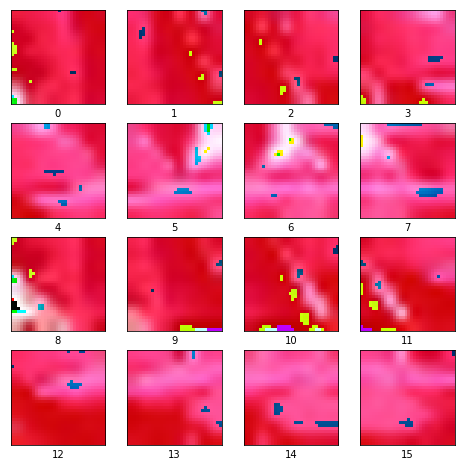

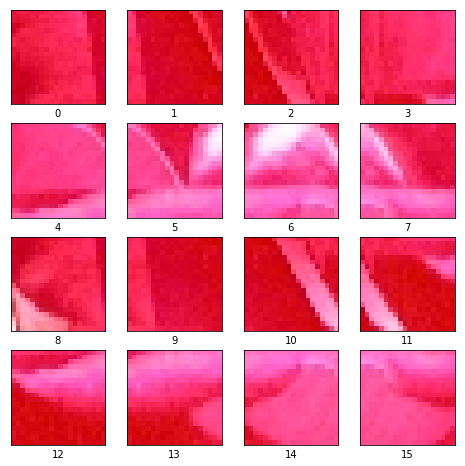

In [5]:
dataset = tf.data.Dataset.list_files("datasets/Train/*.bmp")
dataset = dataset.flat_map(lambda f: parse_function(f, input_size=32, output_size=20, stride=14, scale=4)).apply(tf.data.experimental.unbatch())
print(dataset)
plot_dataset(dataset, 4)
plot_dataset(dataset, 4, input=False)
batched_dataset = dataset.shuffle(1000).batch(100).repeat()

In [6]:
run_id=calendar.timegm(time.gmtime())
log_dir=f"logs/{run_id}/"
print(log_dir)
model.fit(batched_dataset, epochs=3000, steps_per_epoch=100, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir)])

logs/1553003652/
Epoch 1/3000
100/100 [==============================] - 12s 119ms/step - loss: 0.0175 - accuracy: 0.7566
Epoch 2/3000
100/100 [==============================] - 13s 128ms/step - loss: 0.0072 - accuracy: 0.9300
Epoch 3/3000
100/100 [==============================] - 11s 108ms/step - loss: 0.0061 - accuracy: 0.8987
Epoch 4/3000
100/100 [==============================] - 10s 104ms/step - loss: 0.0072 - accuracy: 0.9105
Epoch 5/3000
100/100 [==============================] - 10s 98ms/step - loss: 0.0043 - accuracy: 0.9395
Epoch 6/3000
100/100 [==============================] - 13s 129ms/step - loss: 0.0058 - accuracy: 0.9031
Epoch 7/3000
100/100 [==============================] - 17s 174ms/step - loss: 0.0055 - accuracy: 0.9128
Epoch 8/3000
100/100 [==============================] - 16s 161ms/step - loss: 0.0068 - accuracy: 0.9155
Epoch 9/3000
100/100 [==============================] - 14s 145ms/step - loss: 0.0052 - accuracy: 0.9416
Epoch 10/3000
100/100 [================

100/100 [==============================] - 9s 91ms/step - loss: 0.0041 - accuracy: 0.9416
Epoch 80/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0045 - accuracy: 0.9430
Epoch 81/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0042 - accuracy: 0.9475
Epoch 82/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0033 - accuracy: 0.9126
Epoch 83/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0035 - accuracy: 0.9560
Epoch 84/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0043 - accuracy: 0.9437
Epoch 85/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0037 - accuracy: 0.9042
Epoch 86/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0041 - accuracy: 0.9567
Epoch 87/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0043 - accuracy: 0.9357
Epoch 88/3000
100/100 [==============================] - 9s 90ms/step - loss: 

100/100 [==============================] - 9s 92ms/step - loss: 0.0030 - accuracy: 0.9518
Epoch 235/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0034 - accuracy: 0.9415
Epoch 236/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0038 - accuracy: 0.9511
Epoch 237/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0037 - accuracy: 0.9656
Epoch 238/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0042 - accuracy: 0.9617
Epoch 239/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0035 - accuracy: 0.9251
Epoch 240/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0039 - accuracy: 0.9615
Epoch 241/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0036 - accuracy: 0.9534
Epoch 242/3000
100/100 [==============================] - 11s 108ms/step - loss: 0.0036 - accuracy: 0.9607
Epoch 243/3000
100/100 [==============================] - 13s 131ms/

100/100 [==============================] - 9s 92ms/step - loss: 0.0033 - accuracy: 0.9469
Epoch 313/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0039 - accuracy: 0.9459
Epoch 314/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0037 - accuracy: 0.9509
Epoch 315/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0035 - accuracy: 0.9573
Epoch 316/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0042 - accuracy: 0.9482
Epoch 317/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0040 - accuracy: 0.9681
Epoch 318/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0036 - accuracy: 0.9405
Epoch 319/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0032 - accuracy: 0.9703
Epoch 320/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0039 - accuracy: 0.9359
Epoch 321/3000
100/100 [==============================] - 9s 95ms/step

100/100 [==============================] - 9s 91ms/step - loss: 0.0025 - accuracy: 0.9625
Epoch 467/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0038 - accuracy: 0.9592
Epoch 468/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0037 - accuracy: 0.9563
Epoch 469/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0034 - accuracy: 0.9724
Epoch 470/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0034 - accuracy: 0.9518
Epoch 471/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0042 - accuracy: 0.9480
Epoch 472/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0038 - accuracy: 0.9473
Epoch 473/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0030 - accuracy: 0.9723
Epoch 474/3000
100/100 [==============================] - 10s 96ms/step - loss: 0.0037 - accuracy: 0.9405
Epoch 475/3000
100/100 [==============================] - 9s 89ms/ste

100/100 [==============================] - 9s 88ms/step - loss: 0.0035 - accuracy: 0.9472
Epoch 545/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0029 - accuracy: 0.9674
Epoch 546/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0041 - accuracy: 0.9569
Epoch 547/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0034 - accuracy: 0.9415
Epoch 548/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0039 - accuracy: 0.9484
Epoch 549/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0039 - accuracy: 0.9581
Epoch 550/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0040 - accuracy: 0.9626
Epoch 551/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0037 - accuracy: 0.9412
Epoch 552/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0030 - accuracy: 0.9261
Epoch 553/3000
100/100 [==============================] - 9s 87ms/step

100/100 [==============================] - 9s 85ms/step - loss: 0.0034 - accuracy: 0.9696
Epoch 701/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0035 - accuracy: 0.9481
Epoch 702/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0036 - accuracy: 0.9585
Epoch 703/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0043 - accuracy: 0.9603
Epoch 704/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0034 - accuracy: 0.9555
Epoch 705/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0037 - accuracy: 0.9657
Epoch 706/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0034 - accuracy: 0.9492
Epoch 707/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0033 - accuracy: 0.9604
Epoch 708/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0039 - accuracy: 0.9664
Epoch 709/3000
100/100 [==============================] - 9s 86ms/step

Epoch 855/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0033 - accuracy: 0.9503
Epoch 856/3000
100/100 [==============================] - 10s 99ms/step - loss: 0.0037 - accuracy: 0.9523
Epoch 857/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0035 - accuracy: 0.9560
Epoch 858/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0039 - accuracy: 0.9378
Epoch 859/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0038 - accuracy: 0.9554
Epoch 860/3000
100/100 [==============================] - 11s 107ms/step - loss: 0.0034 - accuracy: 0.9382
Epoch 861/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0036 - accuracy: 0.9635
Epoch 862/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0033 - accuracy: 0.9555
Epoch 863/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0036 - accuracy: 0.9534
Epoch 864/3000
100/100 [============================

100/100 [==============================] - 9s 87ms/step - loss: 0.0030 - accuracy: 0.9616
Epoch 1011/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0034 - accuracy: 0.9706
Epoch 1012/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0041 - accuracy: 0.9533
Epoch 1013/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0032 - accuracy: 0.9264
Epoch 1014/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0032 - accuracy: 0.9563
Epoch 1015/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0045 - accuracy: 0.9614
Epoch 1016/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0041 - accuracy: 0.9535
Epoch 1017/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0022 - accuracy: 0.9597
Epoch 1018/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0041 - accuracy: 0.9535
Epoch 1019/3000
100/100 [==============================] - 9s 

100/100 [==============================] - 10s 95ms/step - loss: 0.0035 - accuracy: 0.9616
Epoch 1165/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0038 - accuracy: 0.9524
Epoch 1166/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0034 - accuracy: 0.9509
Epoch 1167/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0032 - accuracy: 0.9579
Epoch 1168/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0038 - accuracy: 0.9577
Epoch 1169/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0042 - accuracy: 0.9483
Epoch 1170/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0031 - accuracy: 0.9505
Epoch 1171/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0035 - accuracy: 0.9718
Epoch 1172/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0032 - accuracy: 0.9235
Epoch 1173/3000
100/100 [==============================] - 9s

100/100 [==============================] - 9s 93ms/step - loss: 0.0039 - accuracy: 0.9588
Epoch 1242/3000
100/100 [==============================] - 10s 95ms/step - loss: 0.0031 - accuracy: 0.9417
Epoch 1243/3000
100/100 [==============================] - 10s 99ms/step - loss: 0.0039 - accuracy: 0.96480s - loss: 0.0039 - accuracy: 0.
Epoch 1244/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0029 - accuracy: 0.9557
Epoch 1245/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0035 - accuracy: 0.9564
Epoch 1246/3000
100/100 [==============================] - 10s 98ms/step - loss: 0.0036 - accuracy: 0.9636
Epoch 1247/3000
100/100 [==============================] - 10s 97ms/step - loss: 0.0035 - accuracy: 0.9478
Epoch 1248/3000
100/100 [==============================] - 10s 99ms/step - loss: 0.0031 - accuracy: 0.9611
Epoch 1249/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0039 - accuracy: 0.9582
Epoch 1250/3000
100/100 [

100/100 [==============================] - 9s 87ms/step - loss: 0.0030 - accuracy: 0.9666
Epoch 1319/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0037 - accuracy: 0.9683
Epoch 1320/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0034 - accuracy: 0.9332
Epoch 1321/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0043 - accuracy: 0.9571
Epoch 1322/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0030 - accuracy: 0.9616
Epoch 1323/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0031 - accuracy: 0.9554
Epoch 1324/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0034 - accuracy: 0.9723
Epoch 1325/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0036 - accuracy: 0.9423
Epoch 1326/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0037 - accuracy: 0.9663
Epoch 1327/3000
100/100 [==============================] - 11s

100/100 [==============================] - 9s 88ms/step - loss: 0.0038 - accuracy: 0.9660
Epoch 1473/3000
100/100 [==============================] - 10s 97ms/step - loss: 0.0033 - accuracy: 0.9626
Epoch 1474/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0038 - accuracy: 0.9434
Epoch 1475/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0036 - accuracy: 0.9416
Epoch 1476/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0036 - accuracy: 0.9627
Epoch 1477/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0034 - accuracy: 0.9559
Epoch 1478/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0032 - accuracy: 0.9663
Epoch 1479/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0034 - accuracy: 0.9419
Epoch 1480/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0038 - accuracy: 0.9542
Epoch 1481/3000
100/100 [==============================] - 9s

100/100 [==============================] - 10s 103ms/step - loss: 0.0033 - accuracy: 0.9658
Epoch 1627/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0033 - accuracy: 0.9523
Epoch 1628/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0037 - accuracy: 0.9650
Epoch 1629/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0038 - accuracy: 0.9567
Epoch 1630/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0032 - accuracy: 0.9572
Epoch 1631/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0033 - accuracy: 0.9560
Epoch 1632/3000
100/100 [==============================] - 10s 105ms/step - loss: 0.0040 - accuracy: 0.9647
Epoch 1633/3000
100/100 [==============================] - 10s 95ms/step - loss: 0.0034 - accuracy: 0.9388
Epoch 1634/3000
100/100 [==============================] - 10s 96ms/step - loss: 0.0031 - accuracy: 0.9391
Epoch 1635/3000
100/100 [==============================]

100/100 [==============================] - 9s 88ms/step - loss: 0.0035 - accuracy: 0.9601
Epoch 1780/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0030 - accuracy: 0.9458
Epoch 1781/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0037 - accuracy: 0.9649
Epoch 1782/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0035 - accuracy: 0.9336
Epoch 1783/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0034 - accuracy: 0.9430
Epoch 1784/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0036 - accuracy: 0.9570
Epoch 1785/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0038 - accuracy: 0.9428
Epoch 1786/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0033 - accuracy: 0.9567
Epoch 1787/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0033 - accuracy: 0.9524
Epoch 1788/3000
100/100 [==============================] - 9s 

Epoch 1933/3000
100/100 [==============================] - 10s 102ms/step - loss: 0.0034 - accuracy: 0.9366
Epoch 1934/3000
100/100 [==============================] - 10s 97ms/step - loss: 0.0033 - accuracy: 0.9691
Epoch 1935/3000
100/100 [==============================] - 10s 95ms/step - loss: 0.0044 - accuracy: 0.9638
Epoch 1936/3000
100/100 [==============================] - 10s 98ms/step - loss: 0.0024 - accuracy: 0.9614
Epoch 1937/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0035 - accuracy: 0.9585
Epoch 1938/3000
100/100 [==============================] - 10s 96ms/step - loss: 0.0040 - accuracy: 0.9638
Epoch 1939/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0033 - accuracy: 0.9625
Epoch 1940/3000
100/100 [==============================] - 10s 98ms/step - loss: 0.0037 - accuracy: 0.9619
Epoch 1941/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0033 - accuracy: 0.9540
Epoch 1942/3000
100/100 [==============

100/100 [==============================] - 9s 90ms/step - loss: 0.0037 - accuracy: 0.9668
Epoch 2086/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0030 - accuracy: 0.9588
Epoch 2087/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0038 - accuracy: 0.9623
Epoch 2088/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0040 - accuracy: 0.9484
Epoch 2089/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0035 - accuracy: 0.9589
Epoch 2090/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0031 - accuracy: 0.9472
Epoch 2091/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0039 - accuracy: 0.9655
Epoch 2092/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0031 - accuracy: 0.9693
Epoch 2093/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0029 - accuracy: 0.9521
Epoch 2094/3000
100/100 [==============================] - 9s 

100/100 [==============================] - 9s 89ms/step - loss: 0.0035 - accuracy: 0.9636
Epoch 2163/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0035 - accuracy: 0.9606
Epoch 2164/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0030 - accuracy: 0.9272
Epoch 2165/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0039 - accuracy: 0.9528
Epoch 2166/3000
100/100 [==============================] - 10s 97ms/step - loss: 0.0035 - accuracy: 0.9232
Epoch 2167/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0038 - accuracy: 0.9485
Epoch 2168/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0034 - accuracy: 0.9774
Epoch 2169/3000
100/100 [==============================] - 11s 110ms/step - loss: 0.0033 - accuracy: 0.9557
Epoch 2170/3000
100/100 [==============================] - 10s 95ms/step - loss: 0.0036 - accuracy: 0.9511
Epoch 2171/3000
100/100 [==============================] -

100/100 [==============================] - 10s 98ms/step - loss: 0.0026 - accuracy: 0.9674
Epoch 2240/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0042 - accuracy: 0.9533
Epoch 2241/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0029 - accuracy: 0.9538
Epoch 2242/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0044 - accuracy: 0.9452
Epoch 2243/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0032 - accuracy: 0.9578
Epoch 2244/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0024 - accuracy: 0.9746
Epoch 2245/3000
100/100 [==============================] - 10s 101ms/step - loss: 0.0032 - accuracy: 0.9595
Epoch 2246/3000
100/100 [==============================] - 10s 96ms/step - loss: 0.0038 - accuracy: 0.9514
Epoch 2247/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0042 - accuracy: 0.9671
Epoch 2248/3000
100/100 [==============================] -

100/100 [==============================] - 12s 120ms/step - loss: 0.0030 - accuracy: 0.9693
Epoch 2393/3000
100/100 [==============================] - 14s 140ms/step - loss: 0.0040 - accuracy: 0.9577
Epoch 2394/3000
100/100 [==============================] - 15s 155ms/step - loss: 0.0036 - accuracy: 0.9517
Epoch 2395/3000
100/100 [==============================] - 13s 133ms/step - loss: 0.0031 - accuracy: 0.9623
Epoch 2396/3000
100/100 [==============================] - 14s 136ms/step - loss: 0.0024 - accuracy: 0.9672
Epoch 2397/3000
100/100 [==============================] - 11s 108ms/step - loss: 0.0043 - accuracy: 0.9503
Epoch 2398/3000
100/100 [==============================] - 12s 122ms/step - loss: 0.0037 - accuracy: 0.9293
Epoch 2399/3000
100/100 [==============================] - 11s 114ms/step - loss: 0.0033 - accuracy: 0.9732
Epoch 2400/3000
100/100 [==============================] - 11s 111ms/step - loss: 0.0038 - accuracy: 0.9623
Epoch 2401/3000
100/100 [===================

100/100 [==============================] - 8s 85ms/step - loss: 0.0033 - accuracy: 0.9595
Epoch 2546/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0035 - accuracy: 0.9532
Epoch 2547/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0037 - accuracy: 0.9667
Epoch 2548/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0034 - accuracy: 0.9412
Epoch 2549/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0033 - accuracy: 0.9678
Epoch 2550/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0036 - accuracy: 0.9636
Epoch 2551/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0033 - accuracy: 0.9481
Epoch 2552/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0034 - accuracy: 0.9481
Epoch 2553/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0036 - accuracy: 0.9654
Epoch 2554/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 8s 84ms/step - loss: 0.0030 - accuracy: 0.9468
Epoch 2700/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0033 - accuracy: 0.9678
Epoch 2701/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0039 - accuracy: 0.9613
Epoch 2702/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0030 - accuracy: 0.9365
Epoch 2703/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0039 - accuracy: 0.9655
Epoch 2704/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0036 - accuracy: 0.9555
Epoch 2705/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0034 - accuracy: 0.9506
Epoch 2706/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0033 - accuracy: 0.9534
Epoch 2707/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0038 - accuracy: 0.9556
Epoch 2708/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 8s 84ms/step - loss: 0.0030 - accuracy: 0.9697
Epoch 2854/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0029 - accuracy: 0.9418
Epoch 2855/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0050 - accuracy: 0.9406
Epoch 2856/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0031 - accuracy: 0.9675
Epoch 2857/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0029 - accuracy: 0.9744
Epoch 2858/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0029 - accuracy: 0.9724
Epoch 2859/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0040 - accuracy: 0.9327
Epoch 2860/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0031 - accuracy: 0.9594
Epoch 2861/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0042 - accuracy: 0.9565
Epoch 2862/3000
100/100 [==============================] - 8s 

In [7]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir logs/1552873225/

W0320 00:37:22.390996 140425802389312 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0320 00:37:22.407816 140425802389312 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([29.38048  39.045948 34.80726  31.478903], shape=(4,), dtype=float32)
tf.Tensor([29.84035  40.18787  34.70329  31.699226], shape=(4,), dtype=float32)


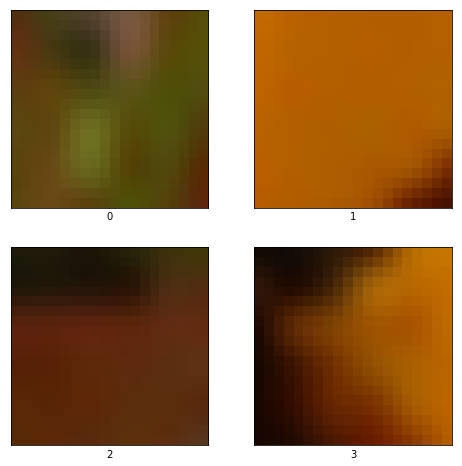

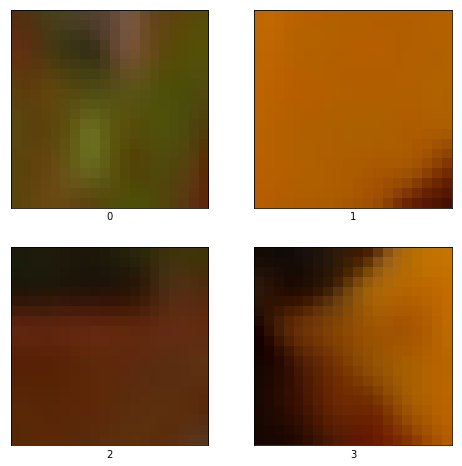

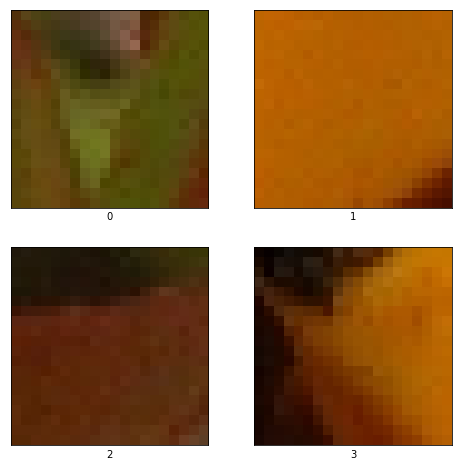

In [8]:
def plot_predictions(d, model, grid_size):
    d_small = d.shuffle(100).take(grid_size**2)
    
    inputs = []
    ground_truth = []
    for i, g in d_small.map(lambda x, y: (x, y)):
        inputs.append(i)
        ground_truth.append(g)
    
    inputs = tf.stack(inputs)
    ground_truth = tf.stack(ground_truth)
    outputs = model.predict(inputs)
    
    _, in_h, in_w, _ = inputs.get_shape()
    _, out_h, out_w, _ = outputs.shape
    new_x = (in_w - out_w) // 2
    new_y = (in_h - out_h) // 2
    inputs = tf.image.crop_to_bounding_box(inputs, new_y, new_x, out_h, out_w)
    
    plot_images(inputs, grid_size)
    plot_images(outputs, grid_size)
    plot_images(ground_truth, grid_size)
    print(tf.image.psnr(inputs, ground_truth, max_val=1.0))
    print(tf.image.psnr(outputs, ground_truth, max_val=1.0))
    
plot_predictions(dataset, model, 2)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  15616     
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2080      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [10]:
import os
model_dir='models'
#os.mkdir(model_dir)
model_path = f"{model_dir}/{run_id}.h5"
model.save(model_path)

W0331 23:11:20.663893 140407507691328 hdf5_format.py:266] Sequential models without an `input_shape` passed to the first layer cannot reload their optimizer state. As a result, your model isstarting with a freshly initialized optimizer.
W0331 23:11:20.918761 140407507691328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(b'datasets/Test/Set5/baby_GT.bmp.png', shape=(), dtype=string)
tf.Tensor(b'datasets/Test/Set5/bird_GT.bmp.png', shape=(), dtype=string)


W0331 23:11:21.011129 140407507691328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 23:11:21.087235 140407507691328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 23:11:21.188567 140407507691328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(b'datasets/Test/Set5/butterfly_GT.bmp.png', shape=(), dtype=string)
tf.Tensor(b'datasets/Test/Set5/head_GT.bmp.png', shape=(), dtype=string)
tf.Tensor(b'datasets/Test/Set5/woman_GT.bmp.png', shape=(), dtype=string)


W0331 23:11:21.280672 140407507691328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


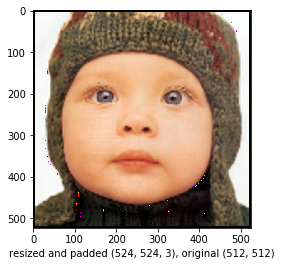

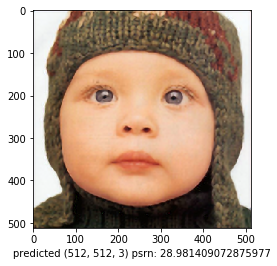

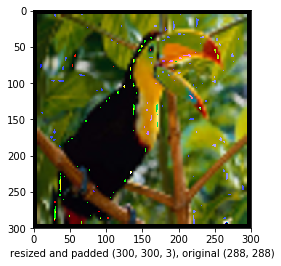

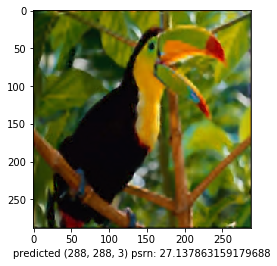

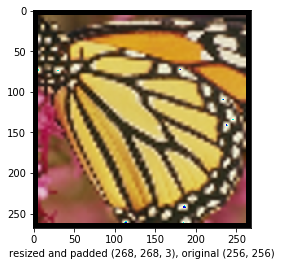

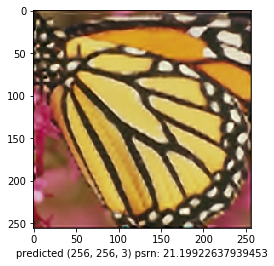

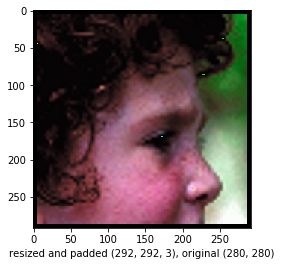

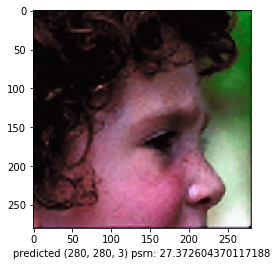

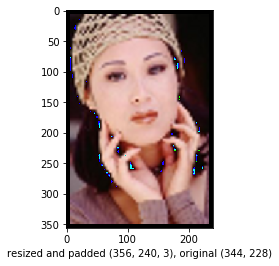

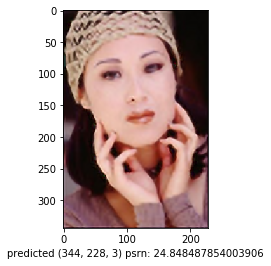

In [33]:
model_dir='models'
model_path = f"{model_dir}/1553003652.h5"
restored_model = tf.keras.models.load_model(model_path)
input_size = 32
output_size=20

for filename in tf.io.matching_files("datasets/Test/Set5/*.bmp"):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string, channels=3)
    ground_truth = image
    h, w, _ = image.get_shape()
    
    image = prepare_input_image(image, h, w, scale=4)
    padding = (input_size - output_size) // 2
    image = tf.pad(image, [[padding, padding], [padding, padding], [0, 0]], "CONSTANT")
    plt.figure()
    plt.imshow(image)
    plt.xlabel(f"resized and padded {image.get_shape()}, original ({h}, {w})")
    
    predicted = restored_model(tf.expand_dims(image, 0))[0]
    psnr = tf.image.psnr(predicted, ground_truth, max_val=1.0)
    
    saved_filename = filename + ".png"
    print(saved_filename)
    tf.io.write_file(saved_filename, tf.image.encode_png(tf.image.convert_image_dtype(predicted, dtype=tf.uint8)))
    
    plt.figure()
    plt.imshow(predicted)
    plt.xlabel(f"predicted {predicted.get_shape()} psrn: {psnr}")
